In [21]:
import datetime
from scapy.all import rdpcap
import pandas as pd
import matplotlib.pyplot as plt

import netifaces as ni

In [79]:
pcap_file = "DATA/real-world-data/capture-20231215-153927.pcap"
interface="eth0"
ip = ni.ifaddresses(interface)[ni.AF_INET][0]['addr']

protocol_names = {6: 'TCP', 17: 'UDP'}

In [11]:
ip

'172.31.28.228'

In [76]:
def extract_field(pcap_file):
    packets = rdpcap(pcap_file)
    packet = packets[0]
    print(f"Packet  Layers and Attributes:") 
    timestamp = datetime.date.fromtimestamp(packet.time).strftime('%Y-%m-%d %H:%M:%S.%f')
    print(f"Packet - Timestamp: {timestamp}")
    # Iterate through the layers
    layer = packet
    while layer:
        layer_name = layer.name
        print(f"  Layer: {layer_name}")
        # Print layer fields
        for field in layer.fields_desc:
            field_name = field.name
            field_value = layer.getfieldval(field_name)
            print(f"    {field_name}: {field_value}")
        # Go to the next layer
        layer = layer.payload
    print("")
extract_field(pcap_file)

Packet  Layers and Attributes:
Packet - Timestamp: 2023-12-15 00:00:00.000000
  Layer: Ethernet
    dst: 02:47:dd:f5:81:7a
    src: 02:d5:32:c5:c9:98
    type: 2048
  Layer: IP
    version: 4
    ihl: 5
    tos: 0
    len: 40
    id: 3464
    flags: DF
    frag: 0
    ttl: 112
    proto: 6
    chksum: 7223
    src: 59.153.220.116
    dst: 172.31.28.228
    options: []
  Layer: TCP
    sport: 4958
    dport: 22
    seq: 516497438
    ack: 985234283
    dataofs: 5
    reserved: 0
    flags: A
    window: 4103
    chksum: 46652
    urgptr: 0
    options: b''



/tmp/ipykernel_1437/3190163821.py:5: DeprecationWarning: an integer is required (got type EDecimal).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  timestamp = datetime.date.fromtimestamp(packet.time).strftime('%Y-%m-%d %H:%M:%S.%f')


In [80]:
def extract_data_from_pcap_scapy(pcap_file):

    packets = rdpcap(pcap_file)

    data = []
    for packet in packets:
        # try:
            if 'IP' in packet:
                timestamp = datetime.datetime.fromtimestamp(packet.time)
                src_ip = packet['IP'].src
                dst_ip = packet['IP'].dst
                dst_port = packet['TCP'].dport if 'TCP' in packet else None
                protocol = protocol_names.get(packet['IP'].proto)
                data.append(
                    (
                        timestamp, 
                        src_ip, 
                        dst_ip, 
                        dst_port, 
                        protocol
                    )
                )
        # except AttributeError:
        #     continue

    return data

In [81]:
pcap_data = extract_data_from_pcap_scapy(pcap_file)
pcap_data

/tmp/ipykernel_1437/2077051721.py:9: DeprecationWarning: an integer is required (got type EDecimal).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  timestamp = datetime.datetime.fromtimestamp(packet.time)


[(datetime.datetime(2023, 12, 15, 15, 39, 27),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '172.31.28.228',
  '59.153.220.116',
  4958,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '172.31.28.228',
  '59.153.220.116',
  4958,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '172.31.28.228',
  '59.153.220.116',
  4958,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 27),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 28),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 28),
  '172.31.28.228',
  '59.153.220.116',
  4958,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 28),
  '59.153.220.116',
  '172.31.28.228',
  22,
  'TCP'),
 (datetime.datetime(2023, 12, 15, 15, 39, 28),
  '172.31.28.228',
  '59.15

In [88]:
df = pd.DataFrame(pcap_data, columns=['Timestamp', 'Source_IP', 'Destination_IP','Destination_Port','Protocol'])
df.head()

,Timestamp,Source_IP,Destination_IP,Destination_Port,Protocol
0,2023-12-15 15:39:27,59.153.220.116,172.31.28.228,22.0,TCP
1,2023-12-15 15:39:27,172.31.28.228,59.153.220.116,4958.0,TCP
2,2023-12-15 15:39:27,59.153.220.116,172.31.28.228,22.0,TCP
3,2023-12-15 15:39:27,172.31.28.228,59.153.220.116,4958.0,TCP
4,2023-12-15 15:39:27,172.31.28.228,59.153.220.116,4958.0,TCP


In [89]:
# Assuming df is your DataFrame with columns 'Timestamp', 'Source_IP', 'Destination_IP'

# Convert 'Timestamp' to datetime if not already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df.set_index('Timestamp', inplace=True)

# Count packets from each source IP
source_ip_counts = df['Source_IP'].value_counts()

# Get the top 5 source IPs
top_source_ips = source_ip_counts.head(5).index

# Filter the DataFrame to include only packets from the top 5 source IPs
filtered_df = df[df['Source_IP'].isin(top_source_ips)]

# Resample and count packets per minute ('T' for minutes)
resampled_df = filtered_df.groupby(['Source_IP']).resample('T').size().unstack(level=0).fillna(0)


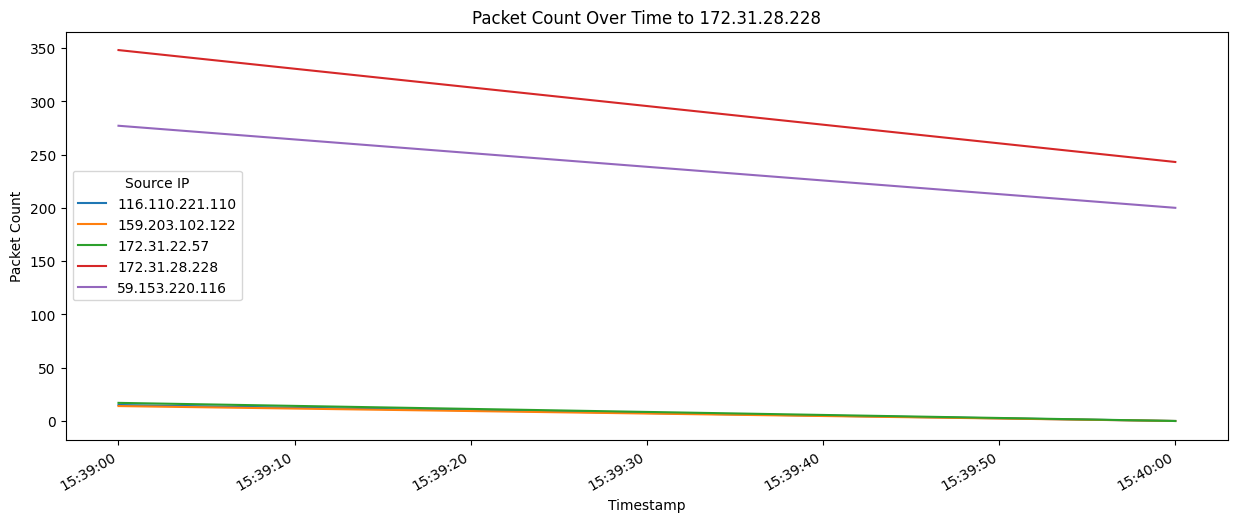

In [90]:
# pivot_table = time_series_data.unstack(level=0).fillna(0)

# Plotting
plt.figure(figsize=(15, 6))
resampled_df.plot(ax=plt.gca())
plt.title(f'Packet Count Over Time to {ip}')
plt.xlabel('Timestamp')
plt.ylabel('Packet Count')
plt.legend(title='Source IP')
plt.show()